<b>Task 1: Positive smile and NOT smile </b>

In [1]:
from __future__ import print_function, division
import torch
import madgrad
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
       'train': transforms.Compose([
               transforms.RandomChoice([
                   transforms.RandomRotation(degrees=(-90, 90)),
                   transforms.ColorJitter(brightness=0.1),
                   transforms.ColorJitter(contrast=0.0),
                   transforms.RandomRotation(degrees=(-90, 90)),
                   transforms.RandomHorizontalFlip(),
                   transforms.ColorJitter(contrast=0.1,brightness=0.1,
                                          saturation=0.1,hue=0.1),  
                   transforms.CenterCrop(224),
           ]),
           transforms.Resize(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
       ]),
    'test': transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'task1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

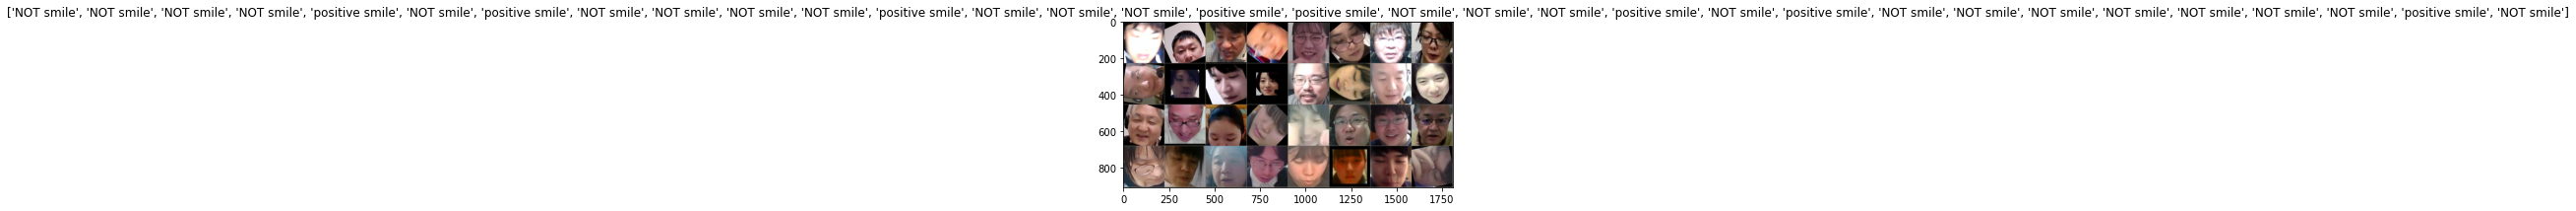

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    val_acc_history = []
    train_acc=[]
    train_loss=[]
    test_loss=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)
                test_loss.append(epoch_loss)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,val_acc_history,test_loss,train_acc,train_loss


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
from efficientnet_pytorch import EfficientNet
model_ft = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.ASGD(model_ft.parameters(), lr=0.01, lambd=0.001, 
                          alpha=0.75, t0=1000000.0, weight_decay=0)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Loaded pretrained weights for efficientnet-b7
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

In [8]:
model_ft,test_acc,test_loss,train_acc,train_loss= train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5755 Acc: 0.7422
test Loss: 0.5412 Acc: 0.8011

Epoch 1/24
----------
train Loss: 0.4837 Acc: 0.7981
test Loss: 0.4266 Acc: 0.8501

Epoch 2/24
----------
train Loss: 0.4192 Acc: 0.8244
test Loss: 0.3546 Acc: 0.8658

Epoch 3/24
----------
train Loss: 0.3708 Acc: 0.8494
test Loss: 0.3250 Acc: 0.8781

Epoch 4/24
----------
train Loss: 0.3445 Acc: 0.8614
test Loss: 0.3088 Acc: 0.8808

Epoch 5/24
----------
train Loss: 0.3269 Acc: 0.8734
test Loss: 0.2972 Acc: 0.8910

Epoch 6/24
----------
train Loss: 0.3010 Acc: 0.8824
test Loss: 0.2958 Acc: 0.8883

Epoch 7/24
----------
train Loss: 0.2902 Acc: 0.8865
test Loss: 0.2953 Acc: 0.8903

Epoch 8/24
----------
train Loss: 0.2989 Acc: 0.8817
test Loss: 0.2935 Acc: 0.8896

Epoch 9/24
----------
train Loss: 0.2951 Acc: 0.8847
test Loss: 0.2929 Acc: 0.8917

Epoch 10/24
----------
train Loss: 0.2852 Acc: 0.8870
test Loss: 0.2929 Acc: 0.8924

Epoch 11/24
----------
train Loss: 0.2892 Acc: 0.8844
test Loss: 0.2913 Acc

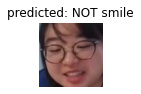

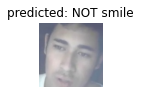

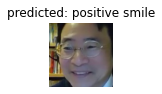

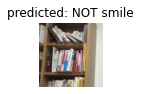

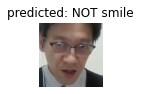

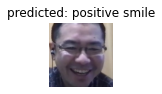

In [9]:
visualize_model(model_ft)

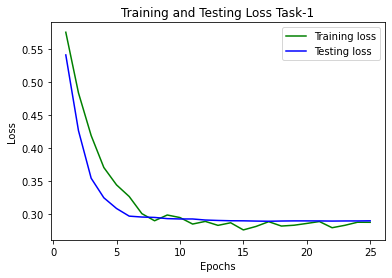

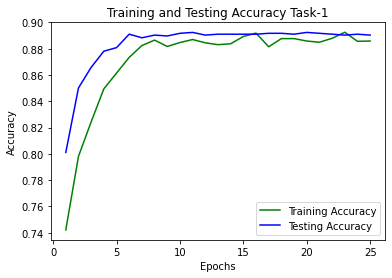

In [13]:
loss_train = train_loss
loss_val = test_loss
epochs = range(1,26)
fig1 = plt.gcf()
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing Loss Task-1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig1.savefig('TrainingTask1.png', dpi=100)
plt.show()

acc_train = train_acc
acc_val = test_acc
epochs = range(1,26)
fig2 = plt.gcf()
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Testing Accuracy')
plt.title('Training and Testing Accuracy Task-1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
fig2.savefig('AccuracyTask1.png', dpi=100)
plt.show()